In [1]:
#
# Statiscical analysis of url_4ecoindex_dataset.csv dataset
#
# First, clone the Python codes and the Dataset from
# https://github.com/christophe-cerin/eco_index-Revisited
# Place all the files, including analysis.ipynb in the same
# directory.
#
# christophe.cerin@univ-grenoble-alpes.fr and mathilde.jay@univ-grenoble-alpes.fr
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

## Importing the dataset and computing basic statistical indicators

In [2]:
d_types = {'DOM_node_number':np.int32, 'request_number':np.int32, 'transfer_size(kB)':np.int32, 'eco_index':np.int32, 'water_consumption(cL)':np.int32, 'gas_emission(gCO2)':np.int32}
df = pd.read_csv(
    "url_4ecoindex_dataset.csv", 
    header=None, 
    names=['URL', 'DOM_node_number', 'request_number', 'transfer_size(kB)', 'eco_index', 'water_consumption(cL)', 'gas_emission(gCO2)'], 
    sep=" ; ", 
    dtype=d_types,
    engine='python',
    )
df['transfer_size(kB)'] = round(df['transfer_size(kB)']/1024,2)
df = df[(df["eco_index"]!=100)&(df["DOM_node_number"]!=0)&(df["request_number"]!=0)&(df["transfer_size(kB)"]!=0)]

In [3]:
#
# check if we have a 'special' anomaly (eco_index == 100)
#
#df[df["eco_index"]==100] # à enlever du dataset
t=df["eco_index"]==100
print(sum(p != False for p in t.tolist()))

0


In [4]:
df.dtypes

URL                       object
DOM_node_number            int32
request_number             int32
transfer_size(kB)        float64
eco_index                   int32
water_consumption(cL)      int32
gas_emission(gCO2)         int32
dtype: object

In [5]:
df.groupby(by='URL').count()['DOM_node_number'].sort_values() # url are unique

URL
http://1080pvideos.net/                 1
https://www.crosskeyspractice.co.uk/    1
https://www.crosscorporategifts.com/    1
https://www.crosscall.com/              1
https://www.crossbaymotorsports.com/    1
                                       ..
https://newhanoverhumanesociety.org/    1
https://newhairdesign.bestilling.nu/    1
https://newgrodno.by/                   1
https://newlms.ipb.ac.id/               1
https://zzztube.com/                    1
Name: DOM_node_number, Length: 98219, dtype: int64

<b>Observation:</b> URLs are unique.

## Distribution of request number, DOM number, and transfer data size parameters

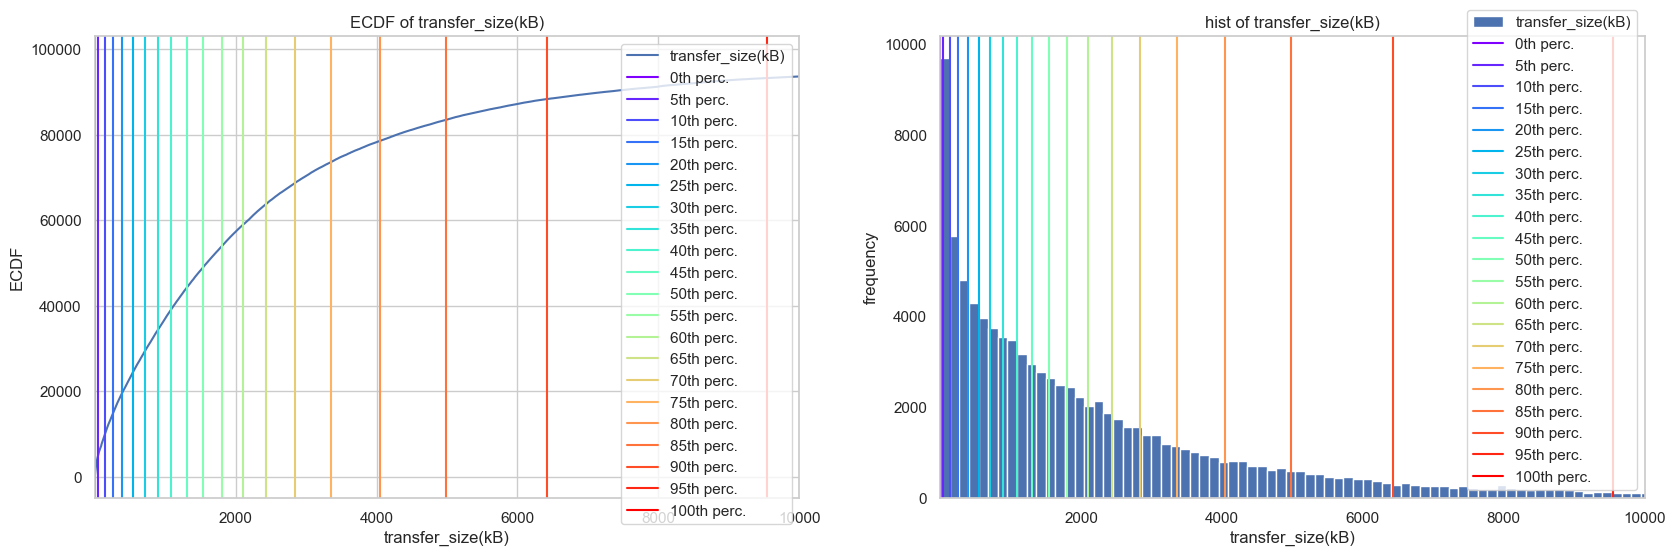

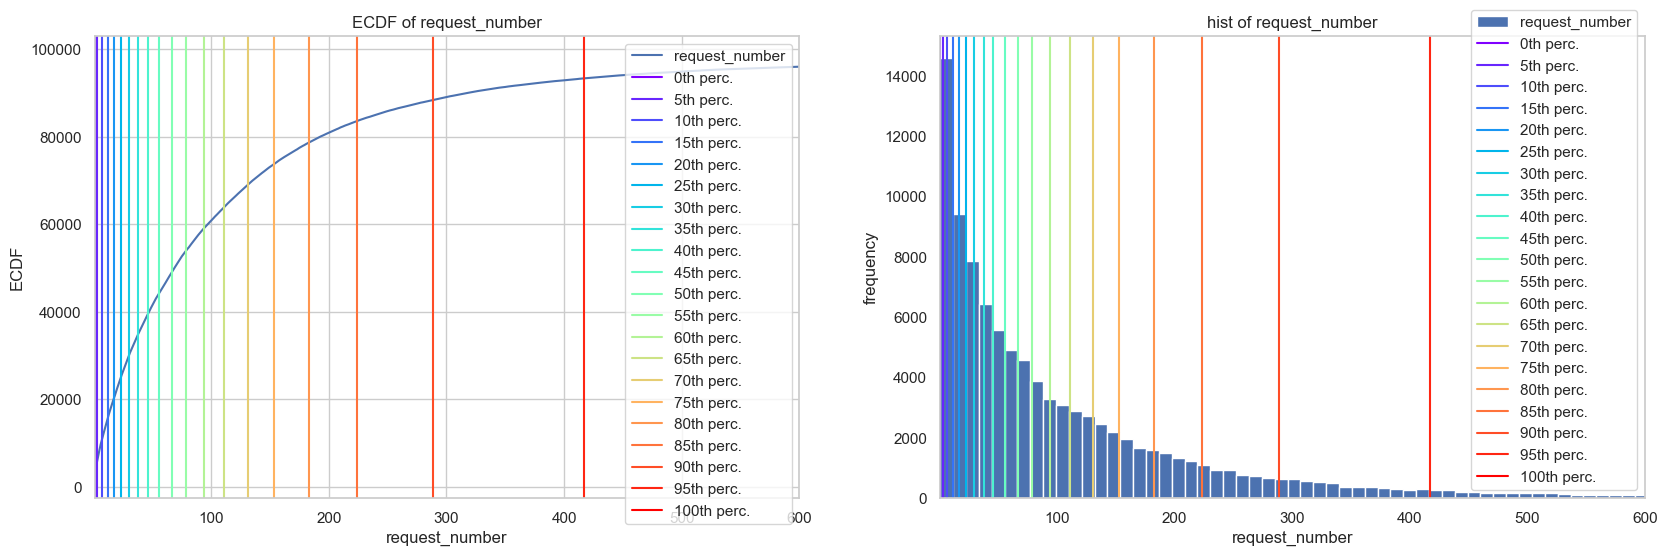

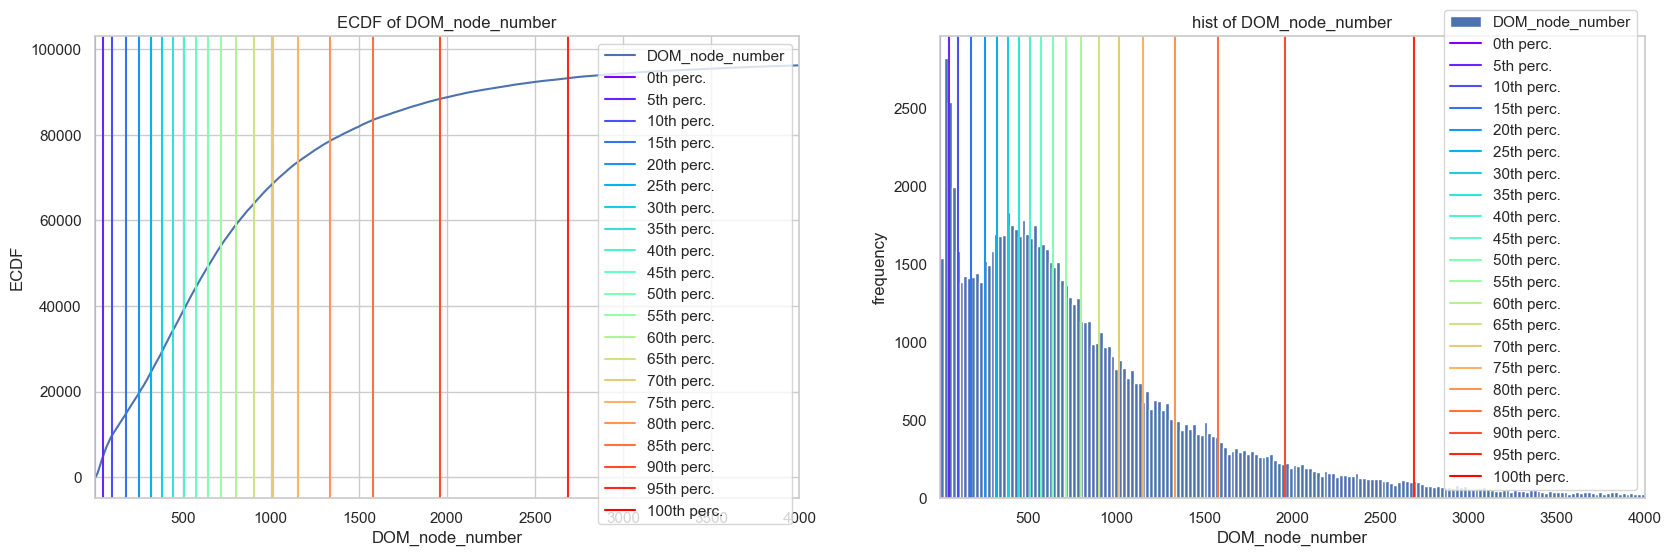

In [6]:
from matplotlib.pyplot import cm

def plot_ecdf(df, col, xmax=None):
    #uniqueHouse = df['Id'].nunique()
    quantiles = {}
    fig, axes = plt.subplots(ncols=2, figsize=(20,6))

    house_price = df[col].value_counts().sort_index().cumsum() #.div(uniqueHouse)
    house_price.plot(x=0,y=1, ax=axes[0])

    df[col].plot.hist(bins=5000, ax=axes[1])

    plt.grid()
    # Calculate and plot the 5 important percentiles
    #colors = ['red','orange','yellow','green','purple','blue','black']
    colors = cm.rainbow(np.linspace(0, 1, 21))
    for i, quantile in enumerate(round(0.05*i,2) for i in range(0,21)):
        quantiles[quantile] = df[col].quantile(quantile)
        axes[0].axvline(df[col].quantile(quantile),label='%.0fth perc.' % (quantile*100) ,color=colors[i])
        axes[1].axvline(df[col].quantile(quantile),label='%.0fth perc.' % (quantile*100) ,color=colors[i])

    axes[0].set_title('ECDF of '+col)
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('ECDF')
    axes[0].set_xlim((df[col].min(), xmax))
    axes[0].legend()

    axes[1].set_title('hist of '+col)
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('frequency')
    if xmax is not None:
        axes[1].set_xlim((df[col].min(), xmax))
    axes[1].legend()
    
    plt.show()
    return quantiles

quantiles = {}
quantiles['transfer_size(kB)'] = plot_ecdf(df, 'transfer_size(kB)', xmax=10**4)
quantiles['request_number'] = plot_ecdf(df, 'request_number', xmax=6*10**2)
quantiles['DOM_node_number'] = plot_ecdf(df, 'DOM_node_number', xmax=4*10**3)

<b>Comments:</b> The models for the parameters i.e., the histograms on the right side of the figure do not follow precisely the same distribution. In particular, the number of DOM nodes does not follow a Poisson distribution like the number of HTTP/HTTPS on the page or the number of kb transferred.

However, consider the left side of the figure, which is the empirical distribution function (also called an empirical Cumulative Distribution Function, eCDF) which is the distribution function associated with the practical measure of a sample. Each value at any specified value of the measured variable (DOM, request, or size) is the fraction of observations of the measured variable that are less than or equal to the specified value. We can again notice the Poisson distribution of the parameters, with a slight difference for the number of DOM nodes.

## Distribution of the eco_index metric for our dataset

<AxesSubplot: ylabel='Frequency'>

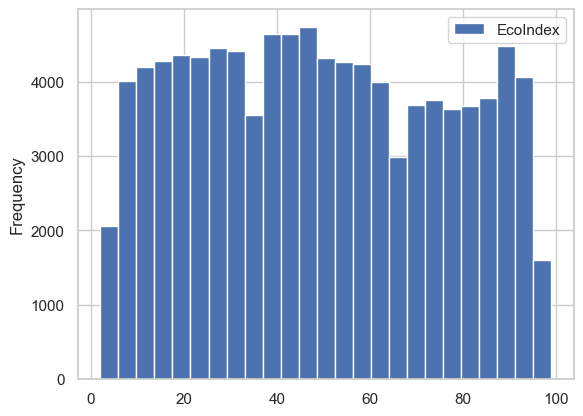

In [7]:
df[['eco_index']].plot.hist(bins=25)

<b>Comments:</b> The ExoIndex has a uniform distribution on our dataset, confirming that our dataset is diverse and big enough regarding the dataset initially used by GreenIT. There is nothing special to notice except that the numbers of values at the extreme part of the spectrum are few, which is expected and confirms that the definition of the eco_index is relevant.

## Impact of each parameter on the eco_index

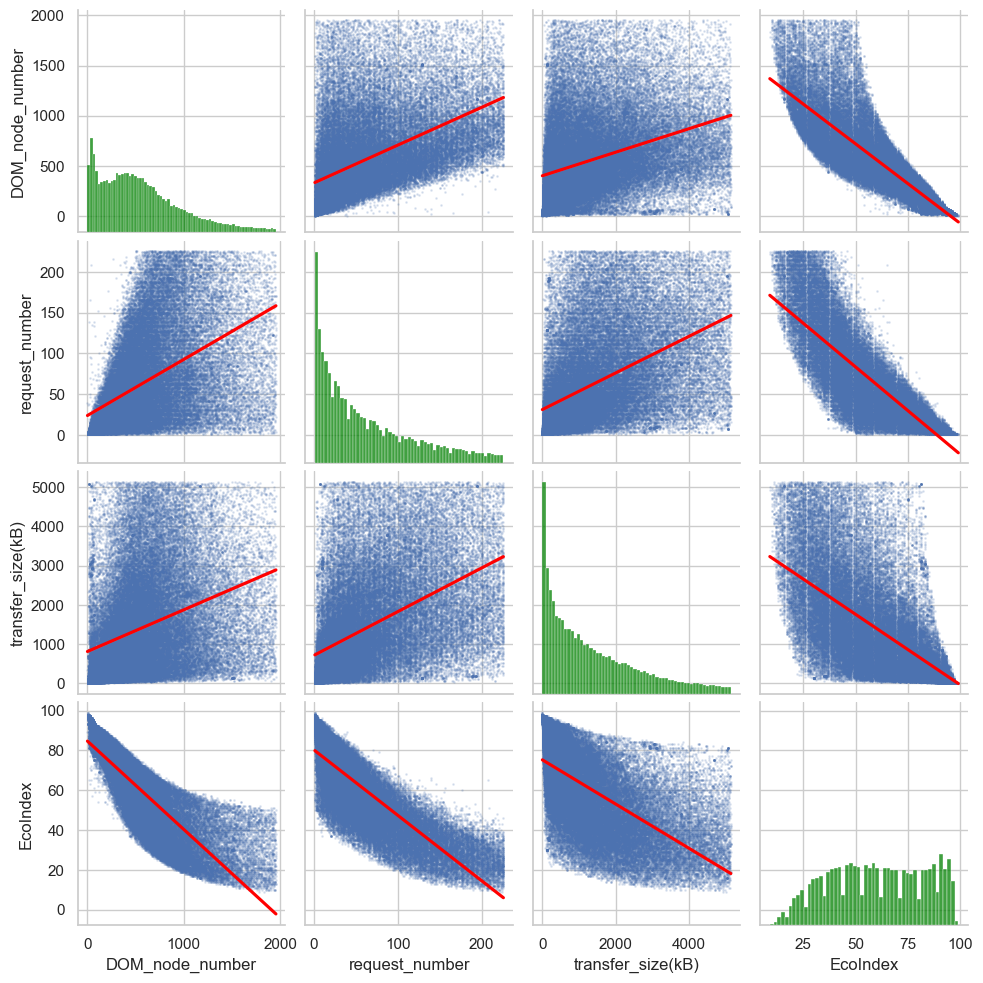

In [8]:
# removing outliers (top 10%)

df_clean = df.copy()
for col in ['DOM_node_number', 'request_number', 'transfer_size(kB)']:
    df_clean = df_clean[df_clean[col] < df_clean[col].quantile(0.9)]

sns.color_palette("tab10")
cols = ['DOM_node_number', 'request_number', 'transfer_size(kB)', 'eco_index']
sns.pairplot(df_clean[cols], kind='reg', diag_kind='hist',plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'alpha':0.15, 's':1}},diag_kws={'color':'green'})

In [9]:
cols = ['DOM_node_number', 'request_number', 'transfer_size(kB)', 'eco_index']
df_clean[cols].corr()

,DOM_node_number,request_number,transfer_size(kB),eco_index
DOM_node_number,1.000000,0.509543,0.353703,-0.839985
request_number,0.509543,1.000000,0.500623,-0.839737
transfer_size(kB),0.353703,0.500623,1.000000,-0.632609
eco_index,-0.839985,-0.839737,-0.632609,1.000000


<b>Comments:</b> The pair plot can be used to understand the best features to explain a relationship between two variables or to form separate clusters. The main-diagonal subplots are the univariate histograms (distributions) for each attribute. We wanted to identify relationships within the scatter plots and applied a linear regression line (in red). The 10% highest values were removed to visualize the distribution better. As a consequence, the distribution of the eco_index is not precisely uniform.


We can notice that the parameters are highly correlated visually. The table shows the correlation between the variables. We can notice that the parameters correlate highly with the eco_index, as was expected. While the number of DOM and the number of requests relate higher than 0.8, the data transfer size has a 0.63 correlation which indicates that it is less significant. If we include the outliers, the correlations drop between 0.3 and 0.6.

## Compute the quantiles from our dataset and make a comparison with the original quantiles

In [10]:
from test_eco_index import quantiles_dom, quantiles_req, quantiles_size, compute_eco_index
original_quantiles = {'DOM_node_number':quantiles_dom, 'request_number':quantiles_req, 'transfer_size(kB)':quantiles_size}

In [11]:
def compute_quantiles(df, col):
    res = []
    quantiles = [round(0.05*i,2) for i in range(0,21)]
    for quantile in quantiles:
        res.append(df[col].quantile(quantile))
    return res

new_quantiles = {}
new_quantiles['transfer_size(kB)'] = compute_quantiles(df, 'transfer_size(kB)')
new_quantiles['request_number'] = compute_quantiles(df, 'request_number')
new_quantiles['DOM_node_number'] = compute_quantiles(df, 'DOM_node_number')

In [12]:
comparison_df = pd.DataFrame(original_quantiles).join(pd.DataFrame(new_quantiles),lsuffix="_original", rsuffix="_new").sort_index(axis=1)

In [13]:
comparison_df

,DOM_node_number_new,DOM_node_number_original,request_number_new,request_number_original,transfer_size(kB)_new,transfer_size(kB)_original
0,1.0,0,1.0,0,0.140,0.00
1,49.0,47,3.0,2,45.616,1.37
2,101.0,75,7.0,15,139.138,144.70
3,177.0,159,12.0,25,254.901,319.53
4,253.0,233,17.0,34,389.336,479.46
5,321.0,298,23.0,42,544.115,631.97
6,385.0,358,30.0,49,713.392,783.38
7,446.0,417,38.0,56,895.158,937.91
8,509.0,476,46.0,63,1088.448,1098.62
9,573.0,537,56.0,70,1302.747,1265.47


<b>Comments:</b> Except for the starting and ending values in the tabular, we observe a relative difference of about 10% between the new and historical values for the quantiles. The difference may be explained by the extreme cases that unbalance the distribution of quantiles, and it is expected.

In [44]:
#
# compute the quantiles for the eco_index column
# The original javascript code considers 10, 25, 40, 55, 70, and 80 as delimiters to give the grades (A-G)
#
def compute_quantiles(df, col):
    res = []
    quantiles = [round(0.125*i,2) for i in range(1,7)]
    #print(quantiles)
    for quantile in quantiles:
        res.append(df[col].quantile(quantile))
    return res

my_quantiles = {}
my_quantiles['eco_index'] = compute_quantiles(df, 'eco_index')
print(my_quantiles)

#
# Second method: use the Pandas quantile() method
#
print(df['eco_index'].quantile(q=[round(0.125*i,2) for i in range(1,7)]))

{'eco_index': [15.0, 27.0, 38.0, 48.0, 59.0, 72.0]}
0.12    15.0
0.25    27.0
0.38    38.0
0.50    48.0
0.62    59.0
0.75    72.0
Name: eco_index, dtype: float64


<b>Comment:</b> We notice a difference between the original Javascript code's delimiters and the eco_index column's quantiles. We cannot justify the values of the delimiters. In any case, they do not correspond to the notion of quantiles.

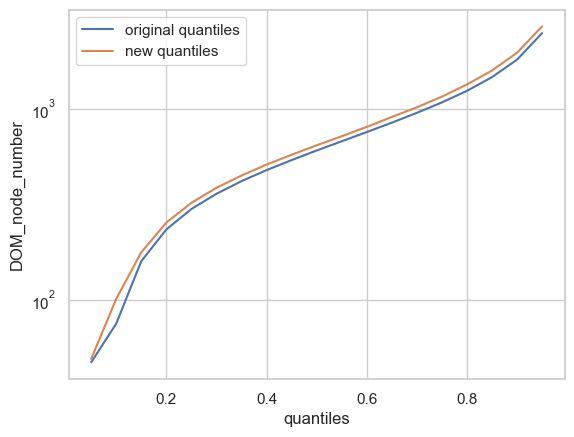

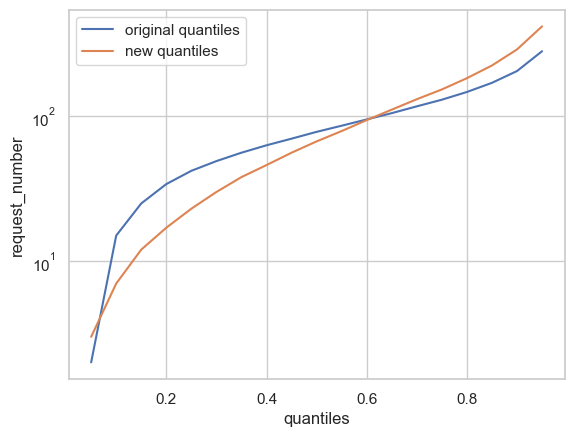

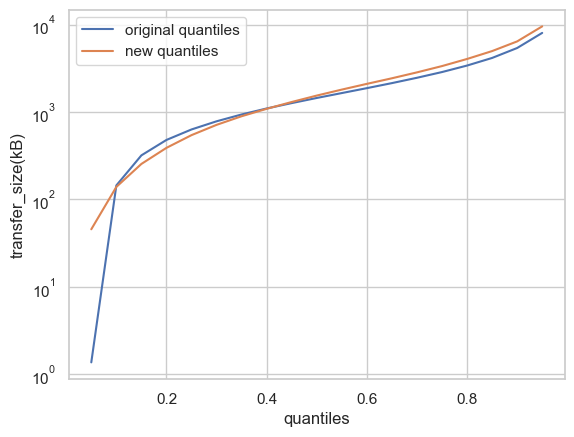

In [30]:
quantiles = [round(0.05*i,2) for i in range(0,21)]
for col in ['DOM_node_number', 'request_number', 'transfer_size(kB)']:
    fig, ax = plt.subplots()
    ax.plot(quantiles[1:-1], original_quantiles[col][1:-1], label="original quantiles")
    ax.plot(quantiles[1:-1], new_quantiles[col][1:-1], label="new quantiles")
    ax.set_yscale('log')
    ax.set_xlabel("quantiles")
    ax.set_ylabel(col)
    # ax.set_title(col + " quantiles")
    ax.legend()
    plt.show()

<b>Comments:</b> Again, the difference in values for the quantiles is relatively small. We observe a larger difference for the request variable.

## Compute the eco_index with new quantiles

In [31]:
from test_eco_index import quantiles_dom, quantiles_req, quantiles_size, compute_quantile

def compute_eco_index(row, quantiles, dom_col, req_col, size_col):
    q_dom = compute_quantile(quantiles[dom_col],row[dom_col])
    q_req = compute_quantile(quantiles[req_col],row[req_col])
    q_size= compute_quantile(quantiles[size_col],row[size_col])
    return 100 - 5 * (3*q_dom + 2*q_req + q_size)/6

df["new_eco_index"] = df.apply(lambda row: compute_eco_index(row, new_quantiles, "DOM_node_number", "request_number", "transfer_size(kB)"), axis=1) #.astype(np.int32)
df["original_eco_index"] = df.apply(lambda row: compute_eco_index(row, original_quantiles, "DOM_node_number", "request_number", "transfer_size(kB)"), axis=1)

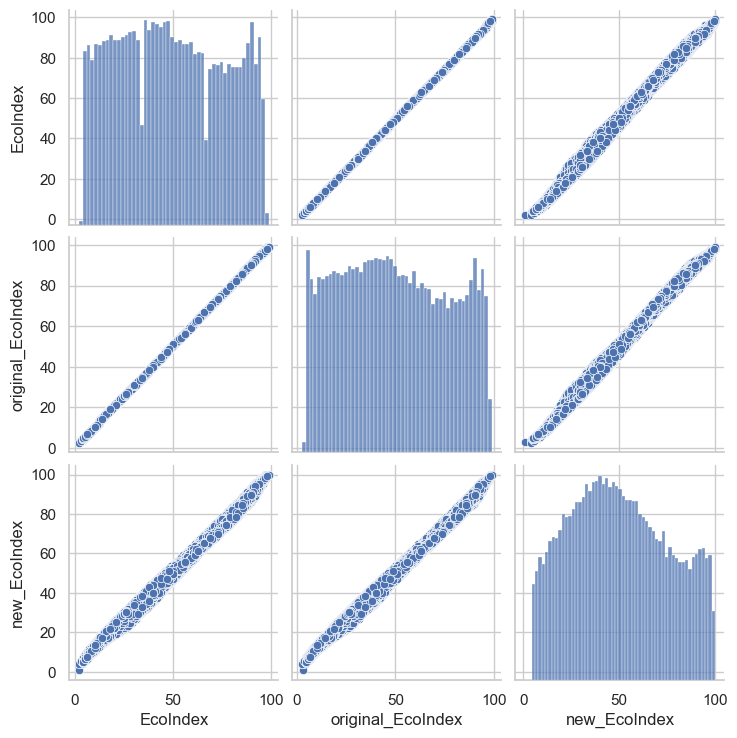

In [32]:
cols = ['eco_index', 'original_eco_index', 'new_eco_index']
sns.pairplot(df[cols])
plt.show()

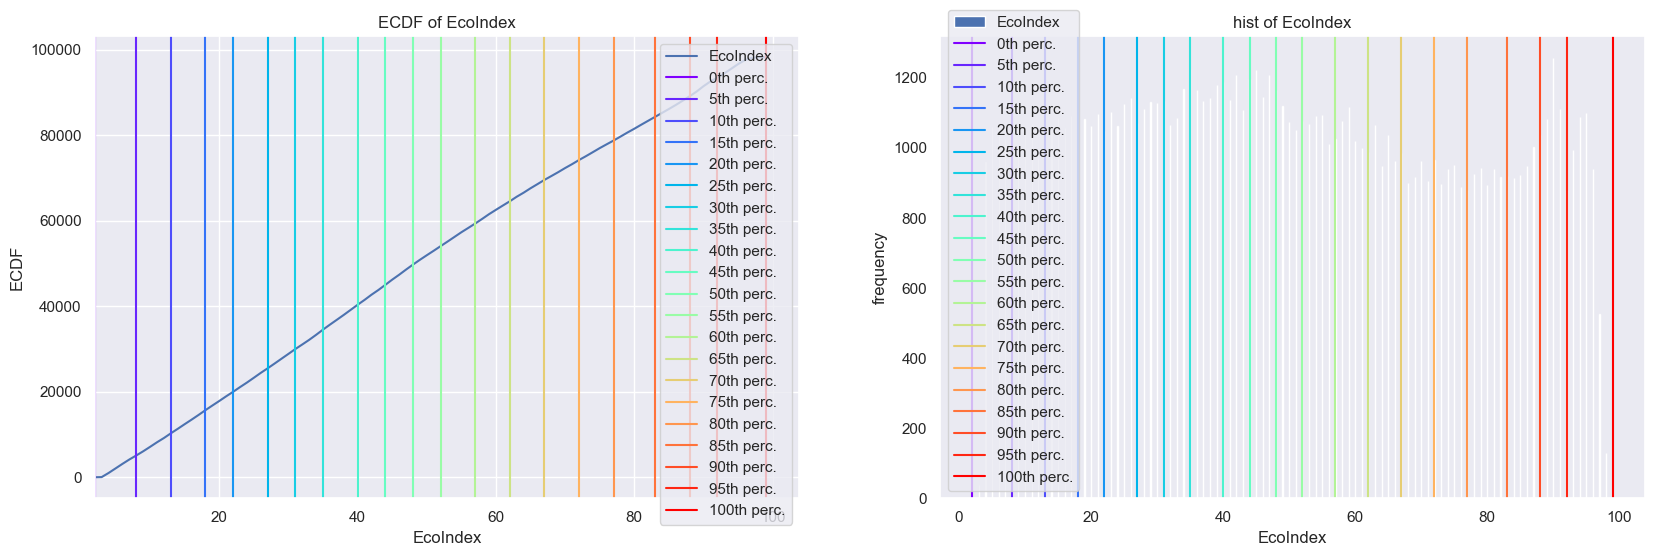

In [33]:
sns.set()
x = plot_ecdf(df, 'eco_index')

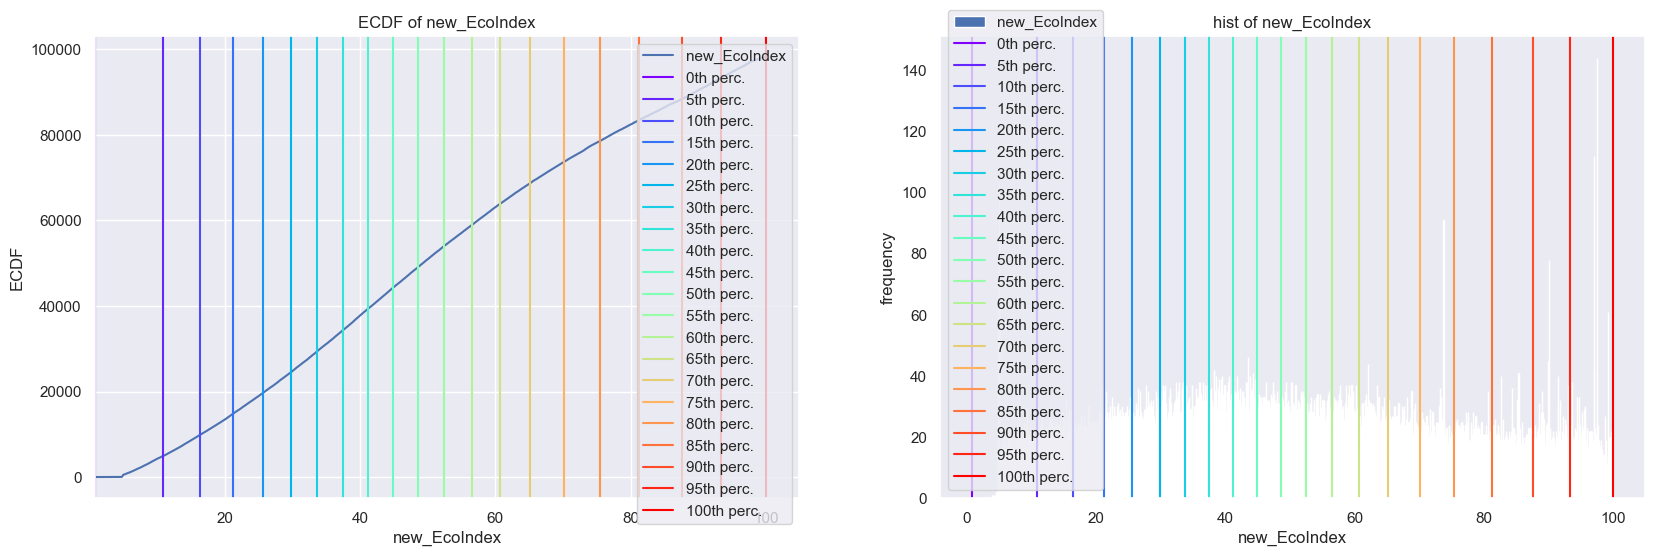

{0.0: 0.8235895750314626,
 0.05: 10.885131067723256,
 0.1: 16.34683140753431,
 0.15: 21.199299296614367,
 0.2: 25.62702300438233,
 0.25: 29.848874222094025,
 0.3: 33.713344178773,
 0.35: 37.51219534162164,
 0.4: 41.14569705967577,
 0.45: 44.828173507951284,
 0.5: 48.59485626233243,
 0.55: 52.4327737080394,
 0.6: 56.520117729724426,
 0.65: 60.669318499378846,
 0.7: 65.17323664285905,
 0.75: 70.08120042559449,
 0.8: 75.4566217890547,
 0.85: 81.25478950279675,
 0.9: 87.53959635196773,
 0.95: 93.31684850231565,
 1.0: 99.9473669261442}

In [34]:
plot_ecdf(df, 'new_eco_index')

<b>Comments:</b> The distribution of the new eco_index, as with the historical eco_index, follows that of the number of DOM nodes, and this is logical since it is the most impactful parameter. The two distributions obtained with new and historical quantiles are close. Intuitively, this point was unexpected, but it confirms a slight variation in the quantiles between 2020 and 2022.

<AxesSubplot: >

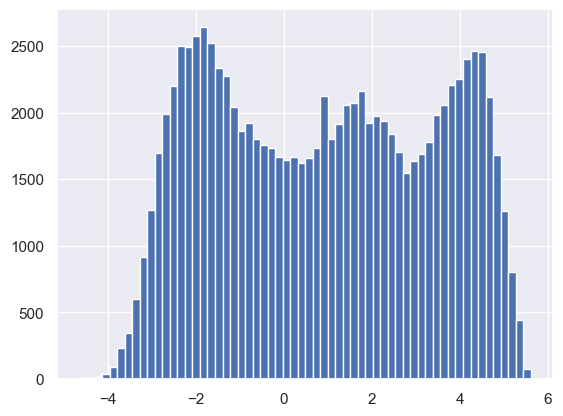

In [35]:
df["diff_eco_index"] = df["new_eco_index"] - df["eco_index"]

df["diff_eco_index"].hist(bins=60)

<b>Comments:</b> With 60 bins for the histogram, we observe that the difference in values for the two eco_index is at a maximum of 2500 and that the difference may be positive or negative, ranging from -4 to +5.5. Since the difference is slight, the two computed eco_index are similar.

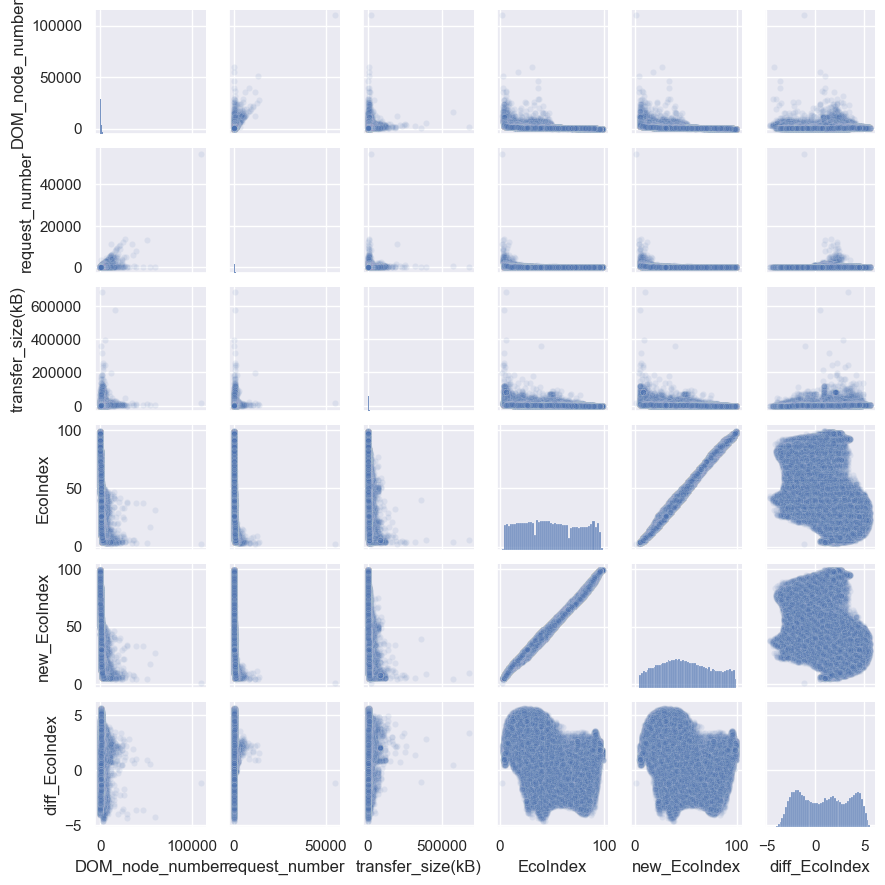

In [36]:
cols = ['DOM_node_number', 'request_number', 'transfer_size(kB)', "eco_index", "new_eco_index", 'diff_eco_index']
sns.pairplot(df[cols], kind="scatter", plot_kws=dict(s=20, alpha=0.1), height=1.5)
plt.show()

<b>Comments:</b>
- Considering the graph at coordinates (diff_eco_index, request_number), the only relationship with the parameters that can be noticed is that the number of requests impacts the new eco_index positively. Indeed, we see many requests, so on the positive side.
- The range of the difference is between -5 and 5, as observed previously, which is minor. See the bottom right subfigure.
- The correlation between the two eco_index is very high visually. See the bottom right subfigures at coordinates (eco_index, new_eco_index) and (new_eco_index, eco_index).
- In considering the graph at coordinate (diff_eco_index, eco_index), the high values of the original eco_index are revised negatively while the low ones are raised. Positive differences are distributed on the top left, and negative ones on the bottom right.

### Others metrics (mainly dissimilarities)

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
#from sklearn import *

In [38]:
explained_variance_score(df["new_eco_index"].values, df["eco_index"].values)

0.9903019907489876

In [39]:
mean_squared_error(df["new_eco_index"].values, df["eco_index"].values)

7.051377709617123

In [40]:
mean_absolute_error(df["new_eco_index"].values, df["eco_index"].values)

2.2728833924609737

In [41]:
#jaccard_score(df["new_eco_index"].values.reshape(-1, 1).astype(int),df["eco_index"].values.reshape(-1, 1), average=None)

from sklearn.metrics import jaccard_score

def flatten(l):
    return [item for sublist in l for item in sublist]

X=flatten(df["new_eco_index"].values.reshape(-1, 1).astype(int))
#print('---------')
Y=flatten(df["eco_index"].values.reshape(-1, 1))

print(jaccard_score(X, Y,average=None))
print(jaccard_score(X, Y, average='micro'))
print(jaccard_score(X, Y, average='macro'))
print(jaccard_score(X, Y, average='weighted'))

[0.         0.         0.08108108 0.48884381 0.13058419 0.03821656
 0.00980392 0.00570776 0.00766703 0.00842697 0.01277275 0.01760176
 0.02896341 0.02653061 0.02379747 0.01365015 0.01675702 0.01867816
 0.01167315 0.01550752 0.01102435 0.01224682 0.02136554 0.01599247
 0.02807971 0.02119982 0.02632773 0.02117336 0.0188845  0.02746781
 0.02813187 0.03107221 0.03214745 0.03414426 0.04560669 0.05152027
 0.04851868 0.04790165 0.05515004 0.04581098 0.04488563 0.04605263
 0.04390452 0.05309    0.04626928 0.06133909 0.0609858  0.06594828
 0.06247231 0.06469003 0.06849953 0.0787254  0.0694051  0.07518797
 0.07330567 0.07038123 0.06904762 0.08481928 0.07333948 0.06907059
 0.0531281  0.05847666 0.04246914 0.03534304 0.02968827 0.03252886
 0.0280083  0.02829162 0.0167206  0.02850995 0.03092784 0.02973568
 0.03349282 0.02763385 0.0284738  0.03003534 0.03880071 0.03933254
 0.04531902 0.05131338 0.08046683 0.05263158 0.07722258 0.086629
 0.06112469 0.07788779 0.11940299 0.15586797 0.21415035 0.259818

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

X=flatten(df["new_eco_index"].values.reshape(-1, 1).astype(int))
#print('---------')
Y=flatten(df["eco_index"].values.reshape(-1, 1))
cos_res = cosine_similarity([X],[Y])

In [43]:
print(cos_res[0][0])

0.9989780893937417


<b>Comments:</b> The cosine similarity metric is close to 1, meaning that the computed eco_index (historical and new) are very similar. Thus, the new quantiles do not significantly impact the measurements. We conclude that we can continue to use them, and we mean the quantiles from the historical eco_index.